In [1]:
!pip install tensorflow==2.2

     |████████████████████████████████| 516.2 MB 4.1 kB/s 
     |████████████████████████████████| 454 kB 66.2 MB/s 
     |████████████████████████████████| 2.9 MB 44.4 MB/s 
     |████████████████████████████████| 3.0 MB 23.5 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboard-2.6.0:
      Successfully uninstalled tensorboard-2.6.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.6.0
    Uninstalli

In [2]:
import os
import cv2
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print("Tensorflow version: ", tf.__version__)

seed = 1234
np.random.seed(seed)
tf.random.set_seed(seed)

Tensorflow version:  2.2.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Loader

Number of normal images found:  4627
Number of augmented images found:  12554
Number of totall images found:  17181
Shape of image:  (128, 512, 3)
Shape of image:  (128, 512, 3)
Shape of image:  (128, 512, 3)
Shape of image:  (128, 512, 3)


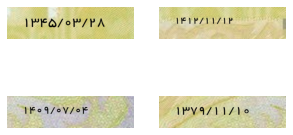

In [4]:
# Path to the train data directory
data_dir_normal = Path("/content/drive/MyDrive/SimpleHTR/dataset/date_train/normal")
data_dir_aug = Path("/content/drive/MyDrive/SimpleHTR/dataset/date_train/augmented")

images_normal = list(data_dir_normal.glob("*.png"))
print("Number of normal images found: ", len(images_normal))

images_aug = list(data_dir_aug.glob("*.png"))
print("Number of augmented images found: ", len(images_aug))

# Get list of all the images
images = images_normal + images_aug
print("Number of totall images found: ", len(images))


# Let's take a look at some samples first. 
# Always look at your data!
sample_images = images[:4]

_,ax = plt.subplots(2,2, figsize=(5,3))
for i in range(4):
    img = cv2.imread(str(sample_images[i]))
    print("Shape of image: ", img.shape)
    ax[i//2, i%2].imshow(img)
    ax[i//2, i%2].axis('off')
plt.show()

Number of normal images found:  1219
Number of augmented images found:  3635
Number of totall images found:  4854
Shape of image:  (128, 512, 3)
Shape of image:  (128, 512, 3)
Shape of image:  (128, 512, 3)
Shape of image:  (128, 512, 3)


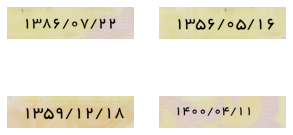

In [5]:
# Path to the test data directory
data_dir_normal = Path("/content/drive/MyDrive/SimpleHTR/dataset/date_test/normal")
data_dir_aug = Path("/content/drive/MyDrive/SimpleHTR/dataset/date_test/augmented")

test_images_normal = list(data_dir_normal.glob("*.png"))
print("Number of normal images found: ", len(test_images_normal))

test_images_aug = list(data_dir_aug.glob("*.png"))
print("Number of augmented images found: ", len(test_images_aug))

# Get list of all the images
test_images = test_images_normal + test_images_aug
print("Number of totall images found: ", len(test_images))


# Let's take a look at some samples first. 
# Always look at your data!
test_sample_images = test_images[:4]

_,ax = plt.subplots(2,2, figsize=(5,3))
for i in range(4):
    img = cv2.imread(str(test_sample_images[i]))
    print("Shape of image: ", img.shape)
    ax[i//2, i%2].imshow(img)
    ax[i//2, i%2].axis('off')
plt.show()

In [6]:
# Store all the characters in a set
characters = set()

# A list to store the length of each date
code_length = []

# Store image-label info
dataset = []

# Iterate over the dataset and store the
# information needed
for img_path in images:
    # 1. Get the label associated with each image
    label = img_path.name.split(".png")[0]
    # 2. Store the length of this cpatcha
    code_length.append(len(label))
    # 3. Store the image-label pair info
    dataset.append((str(img_path), label))
    
    # 4. Store the characters present
    for ch in label:
        characters.add(ch)

# Sort the characters        
characters = sorted(characters)

# Convert the dataset info into a dataframe
dataset = pd.DataFrame(dataset, columns=["img_path", "label"], index=None)

# Shuffle the dataset
dataset = dataset.sample(frac=1.).reset_index(drop=True)


print("Number of unqiue charcaters in the whole dataset: ", len(characters))
print("Maximum length of any date: ", max(Counter(code_length).keys()))
print("Characters present: ", characters)
print("Total number of samples in the dataset: ", len(dataset))
dataset.head()

Number of unqiue charcaters in the whole dataset:  11
Maximum length of any date:  10
Characters present:  ['-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Total number of samples in the dataset:  17181


,img_path,label
0,/content/drive/MyDrive/SimpleHTR/dataset/date_...,1372-06-20
1,/content/drive/MyDrive/SimpleHTR/dataset/date_...,1342-09-18
2,/content/drive/MyDrive/SimpleHTR/dataset/date_...,1410-05-28
3,/content/drive/MyDrive/SimpleHTR/dataset/date_...,1358-11-07
4,/content/drive/MyDrive/SimpleHTR/dataset/date_...,1319-11-13


In [7]:
# Store image-label info
test_dataset = []

# Iterate over the test dataset and store the
# information needed
for img_path in test_images:
    # 1. Get the label associated with each image
    label = img_path.name.split(".png")[0]
    # 2. Store the length of this cpatcha
    code_length.append(len(label))
    # 3. Store the image-label pair info
    test_dataset.append((str(img_path), label))
    

# Convert the test dataset info into a dataframe
test_dataset = pd.DataFrame(test_dataset, columns=["img_path", "label"], index=None)

# Shuffle the test dataset
test_dataset = test_dataset.sample(frac=1.).reset_index(drop=True)

print("Total number of samples in the test dataset: ", len(test_dataset))
test_dataset.head()

Total number of samples in the test dataset:  4854


,img_path,label
0,/content/drive/MyDrive/SimpleHTR/dataset/date_...,1301-10-12
1,/content/drive/MyDrive/SimpleHTR/dataset/date_...,1304-08-28
2,/content/drive/MyDrive/SimpleHTR/dataset/date_...,1344-07-16
3,/content/drive/MyDrive/SimpleHTR/dataset/date_...,1342-09-23
4,/content/drive/MyDrive/SimpleHTR/dataset/date_...,1346-12-12


In [8]:
# Split the dataset into training and validation sets
training_data, validation_data = train_test_split(dataset, test_size=0.2, random_state=seed)

training_data = training_data.reset_index(drop=True)
validation_data = validation_data.reset_index(drop=True)

print("Number of training samples: ", len(training_data))
print("Number of test samples: ", len(validation_data))



# Map text to numeric labels 
char_to_labels = {char:idx for idx, char in enumerate(characters)}

# Map numeric labels to text
labels_to_char = {val:key for key, val in char_to_labels.items()}



# Sanity check for corrupted images
def is_valid_code(code):
    for ch in code:
        if not ch in characters:
            return False
    return True
    
# Store arrays in memory as it's not a muvh big dataset
def generate_arrays(df, resize=True, img_height=128, img_width=512):
    """Generates image array and labels array from a dataframe.
    
    Args:
        df: dataframe from which we want to read the data
        resize (bool)    : whether to resize images or not
        img_weidth (int): width of the resized images
        img_height (int): height of the resized images
        
    Returns:
        images (ndarray): grayscale images
        labels (ndarray): corresponding encoded labels
    """
    
    num_items = len(df)
    images = np.zeros((num_items, img_height, img_width), dtype=np.float32)
    labels = [0]*num_items
    
    for i in range(num_items):
        img = cv2.imread(df["img_path"][i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        if resize: 
            img = cv2.resize(img, (img_width, img_height))
        
        img = (img/255.).astype(np.float32)
        label = df["label"][i]
        
        # Add only if it is a valid code
        if is_valid_code(label):
            images[i, :, :] = img
            labels[i] = label
    
    return images, np.array(labels)



# Build training data
training_data, training_labels = generate_arrays(df=training_data)
print("Number of training images: ", training_data.shape)
print("Number of training labels: ", training_labels.shape)


# Build validation data
validation_data, validation_labels = generate_arrays(df=validation_data)
print("Number of validation images: ", validation_data.shape)
print("Number of validation labels: ", validation_labels.shape)

Number of training samples:  13744
Number of test samples:  3437
Number of training images:  (13744, 128, 512)
Number of training labels:  (13744,)
Number of validation images:  (3437, 128, 512)
Number of validation labels:  (3437,)


In [9]:
# Build test data
test_data, test_labels = generate_arrays(df=test_dataset)
print("Number of test images: ", test_data.shape)
print("Number of test labels: ", test_labels.shape)


Number of test images:  (4854, 128, 512)
Number of test labels:  (4854,)


In [10]:
class DataGenerator(keras.utils.Sequence):
    """Generates batches from a given dataset.
    
    Args:
        data: training or validation data
        labels: corresponding labels
        char_map: dictionary mapping char to labels
        batch_size: size of a single batch
        img_width: width of the resized
        img_height: height of the resized
        downsample_factor: by what factor did the CNN downsample the images
        max_length: maximum length of any code
        shuffle: whether to shuffle data or not after each epoch
    Returns:
        batch_inputs: a dictionary containing batch inputs 
        batch_labels: a batch of corresponding labels 
    """
    
    def __init__(self,
                 data,
                 labels,
                 char_map,
                 batch_size=16,
                 img_width=512,
                 img_height=128,
                 downsample_factor=4,
                 max_length=10,
                 shuffle=True
                ):
        self.data = data
        self.labels = labels
        self.char_map = char_map
        self.batch_size = batch_size
        self.img_width = img_width
        self.img_height = img_height
        self.downsample_factor = downsample_factor
        self.max_length = max_length
        self.shuffle = shuffle
        self.indices = np.arange(len(data))    
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))
    
    def __getitem__(self, idx):
        # 1. Get the next batch indices
        curr_batch_idx = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        
        # 2. This isn't necessary but it can help us save some memory
        # as not all batches the last batch may not have elements
        # equal to the batch_size 
        batch_len = len(curr_batch_idx)
          # 3. Instantiate batch arrays
        batch_images = np.ones((batch_len, self.img_width, self.img_height, 1),
                               dtype=np.float32)
        batch_labels = np.ones((batch_len, self.max_length), dtype=np.float32)
        input_length = np.ones((batch_len, 1), dtype=np.int64) * \
                                (self.img_width // self.downsample_factor - 2)
        label_length = np.zeros((batch_len, 1), dtype=np.int64)
        
        
        for j, idx in enumerate(curr_batch_idx):
            # 1. Get the image and transpose it
            img = self.data[idx].T
            # 2. Add extra dimenison
            img = np.expand_dims(img, axis=-1)
            # 3. Get the correpsonding label
            text = self.labels[idx]
            # 4. Include the pair only if the code is valid
            if is_valid_code(text):
                label = [self.char_map[ch] for ch in text]
                batch_images[j] = img
                batch_labels[j] = label
                label_length[j] = len(text)
        
        batch_inputs = {
                'input_data': batch_images,
                'input_label': batch_labels,
                'input_length': input_length,
                'label_length': label_length,
                }
        return batch_inputs, np.zeros(batch_len).astype(np.float32)
        
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)


In [11]:
# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width=512
img_height=128 

# Factor  by which the image is going to be downsampled
# by the convolutional blocks
downsample_factor=4

# Maximum length of any code in the data
max_length=10

# Get a generator object for the training data
train_data_generator = DataGenerator(data=training_data,
                                     labels=training_labels,
                                     char_map=char_to_labels,
                                     batch_size=batch_size,
                                     img_width=img_width,
                                     img_height=img_height,
                                     downsample_factor=downsample_factor,
                                     max_length=max_length,
                                     shuffle=True
                                    )

# Get a generator object for the validation data 
validation_data_generator = DataGenerator(data=validation_data,
                                     labels=validation_labels,
                                     char_map=char_to_labels,
                                     batch_size=batch_size,
                                     img_width=img_width,
                                     img_height=img_height,
                                     downsample_factor=downsample_factor,
                                     max_length=max_length,
                                     shuffle=False
                                    )

print("Number of train_data_generator: ", len(train_data_generator))
print("Number of validation_data_generator: ", len(validation_data_generator))


Number of train_data_generator:  859
Number of validation_data_generator:  215


In [12]:
# Get a generator object for the test data 
test_data_generator = DataGenerator(data=test_data,
                                     labels=test_labels,
                                     char_map=char_to_labels,
                                     batch_size=batch_size,
                                     img_width=img_width,
                                     img_height=img_height,
                                     downsample_factor=downsample_factor,
                                     max_length=max_length,
                                     shuffle=False
                                    )
print("Number of test_data_generator: ", len(test_data_generator))

Number of test_data_generator:  304


## Model

In [13]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred, input_length, label_length):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        
        # On validation time, just return the computed loss
        return loss

In [14]:
# SimpleHTR model:
#kernel_vals = [5, 5, 3, 3, 3]
#feature_vals = [1, 32, 64, 128, 128, 256]
#stride_vals = pool_vals = [(2, 2), (2, 2), (1, 2), (1, 2), (1, 2)]

def build_model():
    # Inputs to the model
    input_img = layers.Input(shape=(img_width, img_height, 1),
                            name='input_data',
                            dtype='float32')
    labels = layers.Input(name='input_label', shape=[max_length], dtype='float32')
    input_length = layers.Input(name='input_length', shape=[1], dtype='int64')
    label_length = layers.Input(name='label_length', shape=[1], dtype='int64')

    #inputs = keras.layers.Input(shape = (img_width, img_height, 1),name="image")
    conv1 = keras.layers.Conv2D(32, (5,5), activation = 'relu',padding='SAME', name='Conv1')(input_img)
    max1 = keras.layers.MaxPooling2D(pool_size=(2,2), name="pool1")(conv1)
    conv2 = keras.layers.Conv2D(64, (5,5), activation = 'relu', padding='SAME', name='Conv2')(max1)
    max2 =  keras.layers.MaxPooling2D(pool_size=(2,2), name="pool2")(conv2)
    conv3 =  keras.layers.Conv2D(128, (3,3), activation = 'relu',padding='SAME', name='Conv3')(max2)
    max3 =  keras.layers.MaxPooling2D(pool_size=(1,2), name="pool3")(conv3)
    #conv4 = keras.layers.Conv2D(128, (3,3), activation = 'relu',padding='SAME', name='Conv4')(max3)
    #max4 = keras.layers.MaxPooling2D(pool_size=(1,2), name="pool4")(conv4)
    #conv5 = keras.layers.Conv2D(256, (3,3), activation = 'relu',padding='SAME', name='Conv5')(max4)
    #max5 = keras.layers.MaxPooling2D(pool_size=(1,2), name="pool5")(conv5)

    # We have used two max pool with pool size and strides of 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 512. Reshape accordingly before
    # passing it to RNNs
    
    new_shape = ((img_width // 4), (img_height // 4)*64)
    x = layers.Reshape(target_shape=new_shape, name='reshape')(max3)
    x = layers.Dense(64, activation='relu', name='dense1')(x)
    x = layers.Dropout(0.2)(x)
    
    # RNNs
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.2))(x)
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.25))(x)
    
    # Predictions
    x = layers.Dense(len(characters)+1, activation='softmax', name='dense2')(x)
    
    # Calculate CTC
    output = CTCLayer(name='ctc_loss')(labels, x, input_length, label_length)
    
    # Define the model
    model = keras.models.Model(inputs=[input_img,
                                       labels,
                                       input_length,
                                       label_length],
                                outputs=output,
                                name='ocr_model_v1')
    
    # Optimizer
    sgd = keras.optimizers.SGD(learning_rate=0.002,
                               decay=1e-6,
                               momentum=0.9,
                               nesterov=True,
                               clipnorm=5)
    
    # Compile the model and return 
    model.compile(optimizer=sgd)
    return model
 

In [15]:
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_data (InputLayer)         [(None, 512, 128, 1) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 512, 128, 32) 832         input_data[0][0]                 
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 256, 64, 32)  0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 256, 64, 64)  51264       pool1[0][0]                      
_______________________________________________________________________________________

In [16]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss')<0.1):
      self.model.stop_training= True


In [19]:
# Create a callback that saves the model's weights every 50 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/Checkpoints/cp-date.ckpt", 
    verbose=1, 
    save_weights_only=True,
    save_freq=100)

In [ ]:
# Add early stopping
#es = keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
es = myCallback()
# Train the model
history = model.fit(train_data_generator,
                     validation_data=validation_data_generator,
                    epochs=500,
                    callbacks=[es,cp_callback])

Epoch 1/500
 99/859 [==>...........................] - ETA: 1:15:18 - loss: 29.6338
Epoch 00001: saving model to /content/drive/MyDrive/Checkpoints/cp-date.ckpt
199/859 [=====>........................] - ETA: 1:05:42 - loss: 24.4364
Epoch 00001: saving model to /content/drive/MyDrive/Checkpoints/cp-date.ckpt
299/859 [=========>....................] - ETA: 55:45 - loss: 22.5902
Epoch 00001: saving model to /content/drive/MyDrive/Checkpoints/cp-date.ckpt
399/859 [============>.................] - ETA: 45:45 - loss: 21.6140
Epoch 00001: saving model to /content/drive/MyDrive/Checkpoints/cp-date.ckpt
499/859 [================>.............] - ETA: 35:50 - loss: 20.8819
Epoch 00001: saving model to /content/drive/MyDrive/Checkpoints/cp-date.ckpt
599/859 [===================>..........] - ETA: 25:56 - loss: 20.0852
Epoch 00001: saving model to /content/drive/MyDrive/Checkpoints/cp-date.ckpt
699/859 [=======================>......] - ETA: 16:00 - loss: 19.3723
Epoch 00001: saving model to /co

In [ ]:
model.save("/content/drive/MyDrive/Models/train-date-ours.h5", overwrite=True)

## To resume the training where we left off (skip this part)

In [17]:
# Create a basic model instance
model_ckpt2 = build_model()

# Load the previously saved weights
model_ckpt2.load_weights("/content/drive/MyDrive/Checkpoints/cp-date.ckpt")

In [20]:
es = myCallback()
model_ckpt2.fit(train_data_generator, 
          epochs=500,
          callbacks=[es,cp_callback])

Epoch 1/500
 99/859 [==>...........................] - ETA: 1:09:40 - loss: 0.2071
Epoch 00001: saving model to /content/drive/MyDrive/Checkpoints/cp-date.ckpt
199/859 [=====>........................] - ETA: 1:01:22 - loss: 0.1769
Epoch 00001: saving model to /content/drive/MyDrive/Checkpoints/cp-date.ckpt
299/859 [=========>....................] - ETA: 52:31 - loss: 0.1582
Epoch 00001: saving model to /content/drive/MyDrive/Checkpoints/cp-date.ckpt
399/859 [============>.................] - ETA: 43:28 - loss: 0.1392
Epoch 00001: saving model to /content/drive/MyDrive/Checkpoints/cp-date.ckpt
499/859 [================>.............] - ETA: 34:12 - loss: 0.1231
Epoch 00001: saving model to /content/drive/MyDrive/Checkpoints/cp-date.ckpt
599/859 [===================>..........] - ETA: 24:47 - loss: 0.1245
Epoch 00001: saving model to /content/drive/MyDrive/Checkpoints/cp-date.ckpt
699/859 [=======================>......] - ETA: 15:20 - loss: 0.1175
Epoch 00001: saving model to /content/d

In [21]:
model_ckpt2.save("/content/drive/MyDrive/Models/train-date-ours.h5", overwrite=True)

In [22]:
model= model_ckpt2

## Prediction

In [23]:
prediction_model = keras.models.Model(model.get_layer(name='input_data').input,
                                        model.get_layer(name='dense2').output)
prediction_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_data (InputLayer)      [(None, 512, 128, 1)]     0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 512, 128, 32)      832       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 256, 64, 32)       0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 256, 64, 64)       51264     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 128, 32, 64)       0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 128, 32, 128)      73856     
_________________________________________________________________
pool3 (MaxPooling2D)         (None, 128, 16, 128)      0     

In [24]:
prediction_model.save("/content/drive/MyDrive/Models/prediction-date-ours.h5", overwrite=True)

In [ ]:
from tensorflow.keras.models import load_model

prediction_model = load_model("/content/drive/MyDrive/Models/prediction-date-ours.h5")

In [25]:
# A utility to decode the output of the network
def decode_batch_predictions(pred):
    pred = pred[:, :-2]
    input_len = np.ones(pred.shape[0])*pred.shape[1]
    
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, 
                                        input_length=input_len,
                                        greedy=True)[0][0]
    
    # Iterate over the results and get back the text
    output_text = []
    for res in results.numpy():
        outstr = ''
        for c in res:
            if c < len(characters) and c >=0:
                outstr += labels_to_char[c]
        output_text.append(outstr)
    
    # return final text results
    return output_text

In [26]:
#  Let's check results on some test samples
for p, (inp_value, _) in enumerate(test_data_generator):
    bs = inp_value['input_data'].shape[0]
    X_data = inp_value['input_data']
    labels = inp_value['input_label']
    
    preds = prediction_model.predict(X_data)
    pred_texts = decode_batch_predictions(preds)
    
    
    orig_texts = []
    for label in labels:
        text = ''.join([labels_to_char[int(x)] for x in label])
        orig_texts.append(text)
        
    for i in range(bs):
        print(f'Ground truth: {orig_texts[i]} \t Predicted: {pred_texts[i]}')
    break

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Ground truth: 1301-10-12 	 Predicted: 1301-10-12
Ground truth: 1304-08-28 	 Predicted: 1304-08-28
Ground truth: 1344-07-16 	 Predicted: 1344-07-16
Ground truth: 1342-09-23 	 Predicted: 1342-09-23
Ground truth: 1346-12-12 	 Predicted: 1346-12-12
Ground truth: 1352-07-27 	 Predicted: 1352-07-27
Ground truth: 1402-12-17 	 Predicted: 1402-12-17
Ground truth: 1331-04-19 	 Predicted: 1331-04-19
Ground truth: 1302-01-06 	 Predicted: 1302-01-06
Ground truth: 1306-08-09 	 Predicted: 1306-08-09
Ground truth: 1361-07-29 	 Predicted: 1361-07-29
Ground truth: 1399-12-08 	 Predicted: 1399-12-08
Ground truth: 1379-09-16 	 Predicted: 1379-09-16
Ground truth: 1398-11-22 	 Predicted: 1398-11-22
Ground truth: 1355-10-23 	 Predicted: 1355-10-23
Ground truth: 1360-06-19 	 Predicted: 1360-06-19


In [27]:
from sklearn.metrics import confusion_matrix
confusion_matrix(orig_texts, pred_texts)

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

In [28]:
# Accuracy
from sklearn.metrics import accuracy_score
accuracy_score(orig_texts, pred_texts)

1.0

In [29]:
#  Let's check results on some test samples
pred_tests=[]
gt_tests=[]
for p, (inp_value, _) in enumerate(test_data_generator):
    bs = inp_value['input_data'].shape[0]
    X_data = inp_value['input_data']
    labels = inp_value['input_label']
    
    preds = prediction_model.predict(X_data)
    pred_texts = decode_batch_predictions(preds)
    pred_tests= pred_tests + pred_texts

    orig_texts = []
    for label in labels:
        text = ''.join([labels_to_char[int(x)] for x in label])
        orig_texts.append(text)
        gt_tests.append(orig_texts)
'''
    for i in range(bs):
        print(f'Ground truth: {orig_texts[i]} \t Predicted: {pred_texts[i]}')
    print(len(pred_tests))     
    print(len(gt_tests))
'''    

"\n    for i in range(bs):\n        print(f'Ground truth: {orig_texts[i]} \t Predicted: {pred_texts[i]}')\n    print(len(pred_tests))     \n    print(len(gt_tests))\n"

In [30]:
print(len(pred_tests))

4854


In [31]:
# Accuracy
from sklearn.metrics import accuracy_score
accuracy_score(test_labels, pred_tests)

0.9958796868562011

In [ ]:
print(gt_tests)

[['0588927732', '1985571961', '0413678210', '1207568961', '0626101786', '1748159305', '1684782864', '0013899163', '1499624743', '0826284620', '1924744058', '1739804074', '2163547698', '1593672543', '1052281788', '0700411321'], ['0588927732', '1985571961', '0413678210', '1207568961', '0626101786', '1748159305', '1684782864', '0013899163', '1499624743', '0826284620', '1924744058', '1739804074', '2163547698', '1593672543', '1052281788', '0700411321'], ['0588927732', '1985571961', '0413678210', '1207568961', '0626101786', '1748159305', '1684782864', '0013899163', '1499624743', '0826284620', '1924744058', '1739804074', '2163547698', '1593672543', '1052281788', '0700411321'], ['0588927732', '1985571961', '0413678210', '1207568961', '0626101786', '1748159305', '1684782864', '0013899163', '1499624743', '0826284620', '1924744058', '1739804074', '2163547698', '1593672543', '1052281788', '0700411321'], ['0588927732', '1985571961', '0413678210', '1207568961', '0626101786', '1748159305', '168478286

In [ ]:
print(test_labels)

['0588927732' '1985571961' '0413678210' ... '1714532240' '1741954452'
 '0867548029']


In [ ]:
print(pred_tests)

['0588927732', '1985571961', '0413678210', '1207568961', '0626101786', '1748159305', '1684782864', '0013899163', '1499624743', '0826284620', '1924744058', '1739804074', '2163547698', '1593672543', '1052281788', '0700411321', '0904734838', '1195656211', '0757672000', '1457682362', '0572801807', '2121555781', '1457516969', '1869105052', '0869366671', '1961171821', '0628440804', '0076903230', '1957875593', '2021206114', '1540931382', '0426976991', '0154549320', '1633189031', '0048219169', '0709236387', '1756534446', '0917994671', '1873137702', '0572953739', '1619960745', '1387629621', '0686178696', '1541554574', '1144620341', '1629002453', '0785648672', '0886538386', '1060750120', '1740289900', '1387831062', '0381694046', '0826686346', '1593832877', '1457764644', '0634152890', '126183618', '1193940052', '2134920157', '1601099134', '1634947207', '1581651023', '0426589025', '1257010182', '1929945949', '1382031483', '1150593989', '1099819245', '0856012424', '0989187977', '0742942554', '13738

#Conversion from Keras to ONNX

In [32]:
# let's install the onnx packages from the source

!pip install --quiet -U onnxruntime
!pip install --quiet -U git+https://github.com/microsoft/onnxconverter-common
!pip install --quiet -U git+https://github.com/onnx/keras-onnx

     |████████████████████████████████| 4.8 MB 5.2 MB/s 
     |████████████████████████████████| 12.3 MB 184 kB/s 
     |████████████████████████████████| 87 kB 3.6 MB/s 


In [33]:
# convert to onnx model
import keras2onnx
onnx_prediction_model = keras2onnx.convert_keras(prediction_model, 'keras-ours-prediction-onnx')
output_prediction_model_path = "./keras-ours-prediction-model-test.onnx"
# and save the model in ONNX format
keras2onnx.save_model(onnx_prediction_model, output_prediction_model_path)

tf executing eager_mode: True
tf.keras model eager_mode: False
The ONNX operator number change on the optimization: 44 -> 26
